# Loading Neils' Inversions

## Imports

In [1]:
%matplotlib notebook
import os
import gc
import sys
import pickle

import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np

from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs

import scipy.interpolate as interpolate

import math

In [2]:
# pinched from Neil
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
# make a colour map that is typical of AEM plots
rvb = make_colormap(
    [c('b'), c('blue'), 0.05, c('blue'), c('cyan'), 0.33, c('cyan'), c('yellow'), 0.66, c('yellow'),  c('red'), 0.95, c('red'), c('darkred')])


## Loading the .dat file

In [3]:
# setup the file location variables
data_dir = '/g/data1a/zk34/mb4539/ssc/GAData/'
data_file = 'NBC_Stuart_ModelExp_cor2DLog.dat'
hdr_file = 'NBC_Stuart_ModelExp_cor2DLog.hdr'
working_dir = '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Working\\Mike\\'

# build the column name list
# first load the header file
cols = list(pd.read_csv(data_dir + hdr_file, delim_whitespace = True, header = None)[1].values)

# now build the column names for each layer
# number of layers
n = 30
# the names of each column to be repeated n times
col_types = cols[-3::]
# drop the repeated column names
cols = cols[0:-3]
xtra_cols = []
# make the new column names
for col_type in col_types:
    for i in range(1,n+1):
        xtra_cols.append(str(i) + '_' + col_type)
# add the new ones to the existing ones
cols = cols + xtra_cols
cols

['sequence',
 'line',
 'easting',
 'northing',
 'elevation',
 'DataResidual',
 'Residual2',
 'Residual3',
 'TotalResidual',
 'TxHeightMeasured',
 'TxHeightInverted',
 'StdDev_TxHeightInverted',
 'DOI',
 'nlayers',
 '1_resistivity',
 '2_resistivity',
 '3_resistivity',
 '4_resistivity',
 '5_resistivity',
 '6_resistivity',
 '7_resistivity',
 '8_resistivity',
 '9_resistivity',
 '10_resistivity',
 '11_resistivity',
 '12_resistivity',
 '13_resistivity',
 '14_resistivity',
 '15_resistivity',
 '16_resistivity',
 '17_resistivity',
 '18_resistivity',
 '19_resistivity',
 '20_resistivity',
 '21_resistivity',
 '22_resistivity',
 '23_resistivity',
 '24_resistivity',
 '25_resistivity',
 '26_resistivity',
 '27_resistivity',
 '28_resistivity',
 '29_resistivity',
 '30_resistivity',
 '1_resistivity_uncertainty',
 '2_resistivity_uncertainty',
 '3_resistivity_uncertainty',
 '4_resistivity_uncertainty',
 '5_resistivity_uncertainty',
 '6_resistivity_uncertainty',
 '7_resistivity_uncertainty',
 '8_resistivity

In [4]:
# load the data, using the column names created above
data = pd.read_csv(data_dir + data_file, delim_whitespace = True, header = None, names = cols)
# make a geometry column with shapely points
data['geometry'] = data.apply(lambda x: Point((float(x.easting), float(x.northing))), axis=1)
# change to a geodataframe
data = gpd.GeoDataFrame(data, geometry = 'geometry')
# assign the CRS, GDA94 UTM Zone 53 South
data.crs = {'init': 'espg:28353'}
data

I am densified (60 elements)
I am densified (60 elements)


,sequence,line,easting,northing,elevation,DataResidual,Residual2,Residual3,TotalResidual,TxHeightMeasured,...,22_depth_top,23_depth_top,24_depth_top,25_depth_top,26_depth_top,27_depth_top,28_depth_top,29_depth_top,30_depth_top,geometry
0,1,100101,424827.7,7369579.0,466.83,1.321,0.0,0.035,0.138,32.67,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424827.7 7369579)
1,2,100101,424811.1,7369578.0,466.77,1.292,0.0,0.033,0.137,32.31,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424811.1 7369578)
2,3,100101,424794.2,7369577.0,466.79,1.226,0.0,0.032,0.133,31.96,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424794.2 7369577)
3,4,100101,424777.5,7369575.0,466.89,1.191,0.0,0.027,0.131,31.64,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424777.5 7369575)
4,5,100101,424761.0,7369574.0,467.00,1.173,0.0,0.026,0.130,31.38,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424761 7369574)
5,6,100101,424744.5,7369573.0,467.05,1.202,0.0,0.028,0.131,31.18,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424744.5 7369573)
6,7,100101,424728.0,7369573.0,467.02,1.341,0.0,0.035,0.139,31.02,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424728 7369573)
7,8,100101,424711.5,7369572.0,466.95,1.607,0.0,0.042,0.153,30.88,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424711.5 7369572)
8,9,100101,424694.8,7369571.0,466.90,1.786,0.0,0.052,0.162,30.73,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424694.8 7369571)
9,10,100101,424677.9,7369571.0,466.91,2.001,0.0,0.059,0.172,30.56,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (424677.9 7369571)


## Choosing Ti Tree Study Area

In [5]:
# cut the data just to the Ti Tree study area
east_min = 288000
east_max = 426000
north_min = 7450000
north_max = 7600000
data = data[(data['easting'] >= east_min) & (data['easting'] <= east_max) & (data['northing'] >= north_min) & (data['northing'] <= north_max)]

data

I am densified (60 elements)
I am densified (60 elements)


,sequence,line,easting,northing,elevation,DataResidual,Residual2,Residual3,TotalResidual,TxHeightMeasured,...,22_depth_top,23_depth_top,24_depth_top,25_depth_top,26_depth_top,27_depth_top,28_depth_top,29_depth_top,30_depth_top,geometry
152088,13017,118101,337788.3,7512893.0,599.70,20.552,0.0,0.000,0.538,32.46,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337788.3 7512893)
152089,13018,118101,337803.9,7512889.0,599.62,20.590,0.0,0.000,0.539,32.46,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337803.9 7512889)
152090,13019,118101,337819.6,7512885.0,599.58,20.646,0.0,0.000,0.539,32.46,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337819.6 7512885)
152091,13020,118101,337835.2,7512882.0,599.56,20.715,0.0,0.000,0.540,32.48,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337835.2 7512882)
152092,13021,118101,337850.6,7512878.0,599.56,20.781,0.0,0.000,0.541,32.51,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337850.6 7512878)
152093,13022,118101,337866.0,7512874.0,599.57,20.833,0.0,0.000,0.542,32.54,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337866 7512874)
152094,13023,118101,337881.7,7512871.0,599.56,20.870,0.0,0.000,0.542,32.58,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337881.7 7512871)
152095,13024,118101,337897.5,7512867.0,599.53,20.890,0.0,0.000,0.542,32.64,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337897.5 7512867)
152096,13025,118101,337913.3,7512864.0,599.47,20.894,0.0,0.000,0.542,32.71,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337913.3 7512864)
152097,13026,118101,337929.0,7512861.0,599.37,20.888,0.0,0.000,0.542,32.81,...,151.870,176.310,204.660,237.550,275.690,319.950,371.300,430.87,499.99,POINT (337929 7512861)


## Drawing a Section

In [10]:
def getLineData(linenum):
    '''
    This function allows the subsetting and basic processing from the raw data file import to be done on demand.
    
    The desired output is the subset of the datafile related to just the line in question. The data are arranged with
    the westernmost edge of that line as being the first row, and the data following in sequence from there.
    A derived column of distance from the inital point is calculated and included in the returned dataframe.
    
    Function may be extended in the future to deal with conductivity vs resistivity.
    '''
    # subset the line
    line = data[data['line'] == linenum].copy()
    # sort by sequence number (order of points)
    line = line.sort_values(by='sequence')
    # check that the most western point is first. If not, reverse so it is
    if line['easting'].iloc[0] > line['easting'].iloc[-1]:
        line = line[::-1]
    # calculate distance between each fiducial
    line['dist_from_last'] = np.sqrt((line['easting'] - line.shift(1)['easting']) ** 2 +
                                     (line['northing'] - line.shift(1)['northing']) ** 2)
    # tidy up some NaNs
    line['dist_from_last'].iloc[0] = 0
    # calculate cumulative distance along line
    line['cumulative_dist'] = line['dist_from_last'].cumsum()
    line = line.drop(labels = 'dist_from_last', axis =1)
    
    return line

In [11]:
def getSectionData(linenum, z_interval = 1, elevation = True):
    '''
    This function retrives the relevant line data, and based on other parameters, it generates
    a dataframe with an index in either depth below surface or height above sea level, and columns
    in meters along the line from the westernmost point.
    
    The spacing between each layer can be user specified, but an inverval of 1m is recommended.
    
    If the elevation parameter is True, the elevation data for each fiducial is extracted and the
    modelled resisitivity response is essentially "hung" off that elevation. This is achieved by
    changing the index of each fiducial (as a single column dataframe), and then concatenating all
    the fiducials together at the end - pandas conveneinetly inserts np.NaN in the appropriate places.
    '''
    line = getLineData(linenum)
    # select just the resisitivty columns, and transpose
    # this has the effect of taking just the data required and flipping it so that it is ready for display immediately
    # the rest of the code is focuessed on making sure the variable height of each layer is displayed correctly.
    cond_cols = [str(i) + '_resistivity' for i in range(1, n +1)]
    lineT = line[cond_cols].T
    # converting from conductivity to resisitivty
    lineT = 1/lineT
    # rename columns with their cumulative distance values
    lineT.columns = np.round(line['cumulative_dist'], 0).astype(np.int32)
    # rename rows as top depth nums
    depth_cols = [str(i) + '_depth_top' for i in range(1, n +1)]
    z = np.around([data[col].mode()[0] for col in depth_cols],0).astype(np.int16)
    lineT.index = z
    # make a list of intended depths that are NOT in the current index
    # 570 is max as that is the deepest the inversions will model to (in reality much less)
    max_depth = 570
    new_inds = [i for i in range(0, max_depth, z_interval) if i not in lineT.index]
    # insert them into the dataframe and assign them as np.NaN
    for i in new_inds:
        lineT.loc[i] = np.nan
    # sort based on depth
    lineT = lineT.sort_index()
    # forward fill the nans with the last previous valid conductivity
    lineT = lineT.fillna(method = 'ffill')
    
    if elevation:
        # deal with each fiducial by itself, store in a list, then concatenate
        fids = []
        for i, fid in enumerate(lineT.columns):
            # save the fiducial data as a series in a temporary variable
            fid = lineT[fid]   
            
            # get the height of the fiducial in mASL, rounded to the nearest vertical spacing (eg 2m)
            fid_height = myround(line['elevation'].iloc[i], z_interval)
            # reset the index of the series - convert existing depth index to negative (ie below surface),
            # add in altitude of top of fiducial
            fid.index = (-1 * fid.index) + fid_height
            fids.append(fid)
        # combine the results
        lineT = pd.concat(fids, axis = 1)
        # reverse the dataframe so the highest point is at the top (concat sorts ascending)
        lineT = lineT.iloc[::-1]
        
        # need to do something about the odd values that are somehow creeping into the process.
        # need to find them first
        # lineT = lineT.fillna(method = 'ffill')
#         lineT = lineT.drop(lineT.index[lineT.index % 2 == 1], axis = 0)
    
    return lineT

In [12]:
def findClosestLine(data, queryx, queryy):
    '''
    A quick function to find the AEM line that is closest to a given location.
    Designed to be used as part of the interactive line selection tool
    '''
    data['dist_from_point'] = np.sqrt((data['easting'] - queryx)**2 + (data['northing'] - queryy)**2 )
    closestpoint = data['dist_from_point'].argmin()
    data.drop(['dist_from_point'], axis = 1)
    return data.loc[closestpoint]['line']

In [13]:
def myround(x, base):
    """
    Function pinched from https://stackoverflow.com/questions/2272149/round-to-5-or-other-number-in-python
    x is number to be rounded
    base is the number it is to be rounded to
    """
    return int(base * round(float(x)/base))

In [14]:
def drawSection(linenum, z_interval = 2, elevation = False, stretch = 'log',  cmap = 'Spectral'):
    '''
    This function draws up a given AEM line according to the display parameters desired by the user.
    Still needs some work to improve the axis labelling.
    
    Some influence from Neil's Surat AEM coupling notebook
    '''
    # get the rawData (needed for axis labels) and the reformatted grid for plotting
    sectionData = getSectionData(linenum, z_interval, elevation)
    # display the image
    if stretch == 'log':
        imshow(np.log10(sectionData.values), aspect = 'auto', cmap = cmap)
    else:
        imshow(sectionData.values, aspect = 'auto', cmap = cmap)
      
    # customise the appearance of the section
    ax = plt.gca()
    ax.set_title(linenum)
    # add a colourbar
#     plt.colorbar(label='Conductivity')
    
#     xlocs = [len(sectionData.columns) * ( n / 6) for n in range(0, 5)]
#     xticks = [sectionData.columns.max() / n for n in range(0, 5)]    
    ax.set_xlabel('Distance Along Line (m)')
#     ax.set_xticklabels(xticks)
#     ax.set_xticks(xlocs)
    
    if elevation:
        ax.set_ylabel('Elevation (m AHD)')
    else:
        ax.set_ylabel('Depth Below Surface (m)')
    ax.set_yticklabels(sectionData.index)
    
    plt.show()
    
    return ax

In [15]:
def drawMap2(linenum, num_ticks = 4):
    '''
    This function draws a basic map of the AEM lines in the study area.
    It highlights the line specificed.
    It is not using a proper spatial projection, see the currently non-functioning function at the bottom
    of this notebook drawMap for my attempts to get a cartopy based subplot working.
    '''
    # setup the axes tick labels
    xspacing = (data['easting'].max() - data.easting.min()) / (num_ticks + 1)
    yspacing = (data['northing'].max() - data['northing'].min()) / (num_ticks + 1)
    xticks = [int(round(data['easting'].min() + (i + 1) * xspacing,-3)) for i in range(num_ticks)]
    yticks = [int(round(data['northing'].min() + (i + 1) * yspacing,-3)) for i in range(num_ticks)]
    yticks
    
    # subset the data for the line in question
    line = data[data['line'] == linenum]
    
    # plot the data, doing the transforms and projectiosn are required
    plt.plot(data['easting'], data['northing'], 'r.')
    plt.plot(line['easting'], line['northing'], 'b.')
    ax = plt.gca()
    ax.set_title('Ti Tree Area, South Stuart Corridor')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    return ax

In [16]:
global new_line
pv_picks = {line:{'height':[], 'depth':[]} for line in data['line'].unique()}

def analysis(linenum, z_interval = 2, elevation = False, stretch = 'log',  cmap = 'Spectral'):
    """
    This is the wrapper function that sorts out all the plotting stuff and facilitates the interactivtiy.
    """
    def onclick(event):
        """
        This is the action to do for a mouse click event.

        If the click is the user picking the base of the paleovalley, the results are stored in the pv_picks
        dict for subsequent processing.    
        
        Future work includes improving the test for which axes the click event occurs in.
        """
        # defining what to do on a click event
        
        x, y = event.xdata, event.ydata
        # dumb test for if in map or section
        # should be using the event.inaxes property, but don't understand how it works
        if x > 100000 and y > 100000:
            global new_line
            new_line = findClosestLine(data, x, y)
            ax1 = fig.add_axes([0.15, 0.45,0.5, 0.5]) # bottom left x pos, bottom left y pos, width, height
            ax1.clear()
            ax1 = drawMap2(new_line)

            ax2 = fig.add_axes([0.1, 0.05,0.85, 0.2])
            ax2.clear()
            ax2 = drawSection(new_line, z_interval, elevation, stretch, cmap)
            plt.draw()
        
        else:
            if elevation:
                pv_picks[new_line]['height'].append((x,y)) 
            else:
                pv_picks[new_line]['depth'].append((x, y))         
    
    # create the figure, define the figure size
    global new_line
    new_line = linenum
    fig = plt.figure(figsize=[10,9]) # across, high
    
    # create the axes in the appropriate places
    ax1 = fig.add_axes([0.15, 0.45,0.5, 0.5]) # bottom left x pos, bottom left y pos, width, height
    ax1.clear()
    ax1 = drawMap2(linenum)
    
    ax2 = fig.add_axes([0.1, 0.05,0.85, 0.2])
    ax2.clear()
    ax2 = drawSection(linenum, z_interval, elevation, stretch, cmap)
    plt.draw()
    
    # connect the click event action to the figure
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Running It

<IPython.core.display.Javascript object>


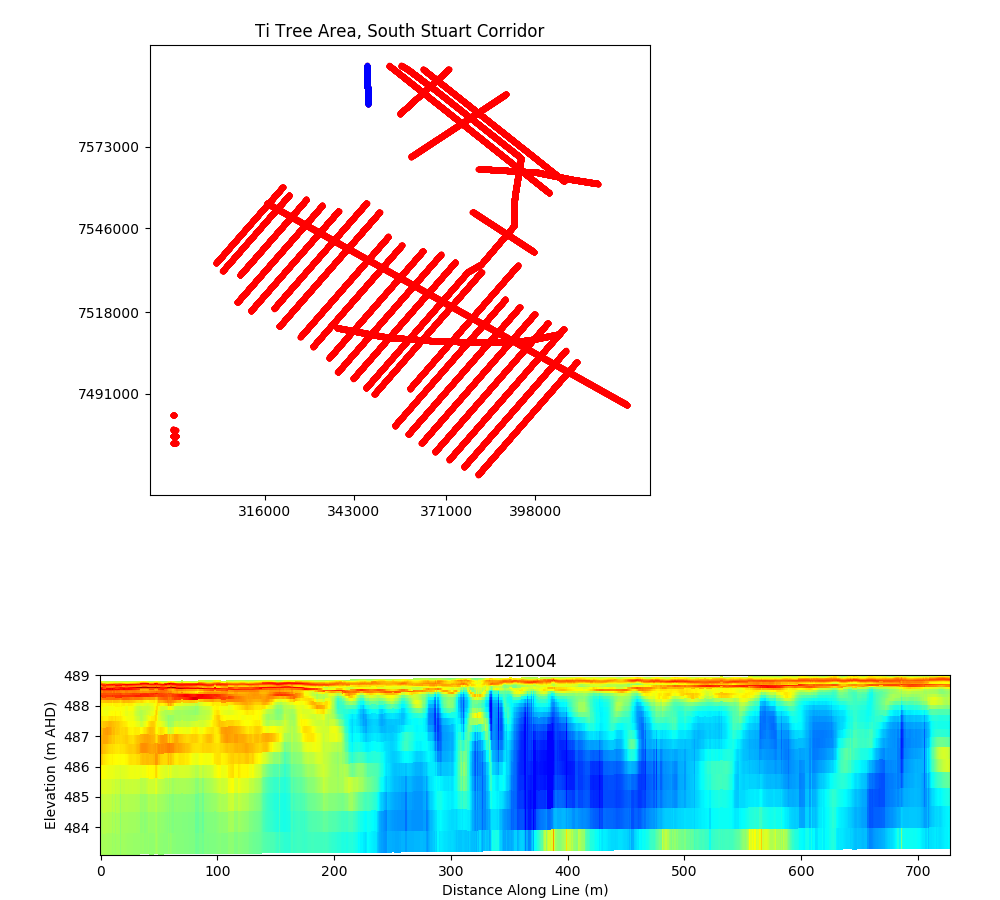

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
analysis(118801, z_interval = 1, elevation = True, stretch = 'log', cmap = rvb)

# Processing the Picks

In [7]:
# pv_picks = pd.read_pickle('../GAData/all_TT_PV_allpicks.pkl')
pd.read_pickle('../GAData/all_TT_PV_allpicks.pkl')

In [8]:
pv_picks

{118101: {'height': [], 'depth': []},
 118201: {'height': [], 'depth': []},
 118251: {'height': [(999.2496139705884, 86.15104166666663),
   (1042.1449080882353, 520.0677083333333),
   (1191.1496139705882, 548.2899305555555),
   (1362.7307904411766, 548.2899305555555),
   (1471.097849264706, 407.1788194444444),
   (1563.6613786764708, 269.5954861111111),
   (1622.3602022058824, 135.53993055555554),
   (1723.9543198529414, 93.20659722222217),
   (1787.1684375000002, 93.20659722222217)],
  'depth': []},
 118301: {'height': [(830.6013786764702, 76.28645833333326),
   (893.8896139705878, 76.28645833333326),
   (970.2719669117644, 119.0197916666666),
   (1044.4719669117644, 175.99756944444437),
   (1085.9366727941172, 528.5475694444444),
   (1155.7719669117644, 617.5753472222223),
   (1363.095496323529, 621.1364583333333),
   (1454.7543198529406, 475.13090277777775),
   (1507.130790441176, 289.95312499999994),
   (1552.9602022058818, 165.3142361111111),
   (1633.7072610294113, 122.5809027777

In [20]:
# linenum = 120401
# vert_datum = 'height'
vert_datum_lookup = {'height':True, 'depth':False}
data['depth_to_basement'] = np.nan
# index = 0
# xcoord, ycoord = pv_picks[linenum][vert_datum][index]

# the goal of this bunch of code is to:
#   - convert the user base paleovalley picks from image/pixel coordinates into depth/dist along line coords
#   - convert these coordinates into a shapely linestring object for each AEM line
#   - convert each fiducial for that AEM line into a shapely line on the same coordinate system
#   - calculate the intersection (if any) between that fiducial and the base paleovalley line
#   - save the intersection depth back onto the original main dataset

for linenum in pv_picks.keys():
    # make a place to store the data for the base paleovalley horizon
    if (not bool(pv_picks[linenum]['height'])) and (not bool(pv_picks[linenum]['depth'])):
        continue
    base_valley_combined = []
    for vert_datum in pv_picks[linenum].keys():
        # load the data
        base_valley = pd.DataFrame(columns = ['x','z'])
        sec_data = getSectionData(linenum, z_interval = 1, elevation = vert_datum_lookup[vert_datum])
        for coord in pv_picks[linenum][vert_datum]:

            # unpack the x and z coords
            xcoord, zcoord = coord
            # find the depth that z coord (in pixels from the image array) corresponds to
            depth = sec_data.index[int(zcoord)]
            # find the distance along the line that hte x coord (in pixels from the image array) corresponds to
            fid_dist = sec_data.columns[int(xcoord)]
            # store the results in the dataframe
            base_valley.loc[len(base_valley)] = (fid_dist, depth)

            if vert_datum == 'depth':
                # if the section has been picked in depth, need to convert current depth below surface values
                # get the elevation data for that line
                elev = getLineData(linenum)[['elevation','cumulative_dist']]
                # format the cumulative distance so it can be used as a comparable index
                elev['cumulative_dist'] = np.round(elev['cumulative_dist'],0)
                elev = elev.set_index('cumulative_dist')
                # the altitude of the pick = depth + *1 + height of surface (ie surface height - depth below surface)
                base_valley['z'] = -1 * base_valley['z'].values + elev.loc[base_valley['x'].values, 'elevation'].values

        # combine the height and depth based picks (if they both exist)
        base_valley_combined.append(base_valley)

    # concatenate, sort by x (ie distance along line)
    base_valley_combined = pd.concat(base_valley_combined, axis = 0)
    base_valley_combined = base_valley_combined.sort_values(by = 'x')
    # create the base paleovalley line
    base_pv = LineString(zip(base_valley_combined['x'], base_valley_combined['z']))    
    # make a blank dataframe to store the InterseCtion depthS for each fiducial
    line_ics = pd.DataFrame(columns = ['x','z'], index = sec_data.columns)

    for x in sec_data.columns:
        # build each fiducial into a line and test if it intersects the base paleovalley line
        # if so, store the results in the dataframe, if not, store nan
        fid_top = sec_data[x].index.max()
        fid_bott = sec_data[x].index.min()
        fid_line = LineString([(x, fid_top), (x, fid_bott)])
        try:
            line_ics.loc[x] = base_pv.intersection(fid_line).coords[0]
        except:
            line_ics.loc[x] = x, np.nan

    # retrieve the line data
    line_data = getLineData(linenum)
    # make a column to store depth to basement for this line
    # requires that line_data and line_ics be sorted exactly the same (should be implicit from process)
    line_data['depth_to_basement'] = line_ics['z'].values
    # use the index from line_data to select the relevant rows in data, and assign the appropriate values
    # cells are aligned explictly by this process.
    data.loc[line_data.index, 'depth_to_basement'] = line_data['depth_to_basement'].values  

# assume that the western most and eastern most points are the edge of the pv
    # might need to deal with edge cases for lines that are split in 2....or combine the lines before the picking process

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/geopandas/geodataframe.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [21]:
data[data['depth_to_basement'].notna()]

I am densified (0 elements)


,sequence,line,easting,northing,elevation,DataResidual,Residual2,Residual3,TotalResidual,TxHeightMeasured,...,23_depth_top,24_depth_top,25_depth_top,26_depth_top,27_depth_top,28_depth_top,29_depth_top,30_depth_top,geometry,depth_to_basement


# Save the important stuff

In [24]:
with open('all_TT_PV_allpicks.pkl', 'wb') as f:
    pickle.dump(pv_picks, f)

In [25]:
data.to_pickle('TT_AEM_with_allPVDepth.pkl', protocol=2)

# OLD STUFF

In [ ]:
# function to create a spatially correct map of the study area
# can't get it working as part of an interactive subplot thing
def drawMap(linenum, num_ticks = 4):
    # setup the axes tick labels
    xspacing = (data['easting'].max() - data.easting.min()) / (num_ticks + 1)
    yspacing = (data['northing'].max() - data['northing'].min()) / (num_ticks + 1)
    xticks = [int(round(data['easting'].min() + (i + 1) * xspacing,-3)) for i in range(num_ticks)]
    yticks = [int(round(data['northing'].min() + (i + 1) * yspacing,-3)) for i in range(num_ticks)]
    yticks
    
    # subset the data for the line in question
    line = data[data['line'] == linenum]
    
    # define the CRS used for the mapping (cartopy based CRS)
    mapcrs = ccrs.UTM(53, True)

    # plot the data, doing the transforms and projectiosn are required
    plt.subplot(projection = mapcrs)
    plt.plot(data['easting'], data['northing'], 'r.', transform = mapcrs)
    plt.plot(line['easting'], line['northing'], 'b.', transform = mapcrs)
    ax = plt.gca()
    ax.set_xticks(xticks, crs = mapcrs)
    ax.set_yticks(yticks, crs = mapcrs)
    
    return ax